In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from opxrd.wrapper import OpXRD

# ------------------------------------------------------------

smoltest_dirpath = '/home/daniel/aimat/data/opXRD/test_smol'
bigtest_dirpath = '/home/daniel/aimat/data/opXRD/test'
test_databases = OpXRD.load_project_list(root_dirpath=smoltest_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test_smol
[2024-12-22 14:19:55]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/USC


100% (174 of 174) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-22 14:19:55]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/USC
[2024-12-22 14:19:55]: Successfully extracted 174 patterns from 174/174 xrd files
[2024-12-22 14:19:55]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/CNRS


100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-22 14:19:55]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/CNRS
[2024-12-22 14:19:55]: Successfully extracted 27 patterns from 27/27 xrd files


In [3]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=test_databases, output_dirpath='/tmp/opxrd_analysis')

---> Fourier transform of gaussians of the form $I(x) = e^{{-0.5(x-b)^2/c}$

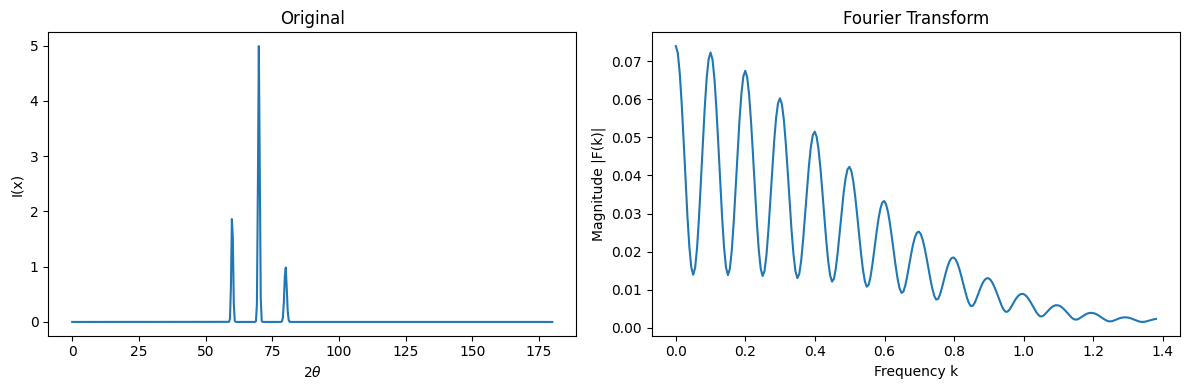

---> Fourier transform of gaussians of the form $I(x) = e^{{-0.5(x-b)^2/c}$ with added noise

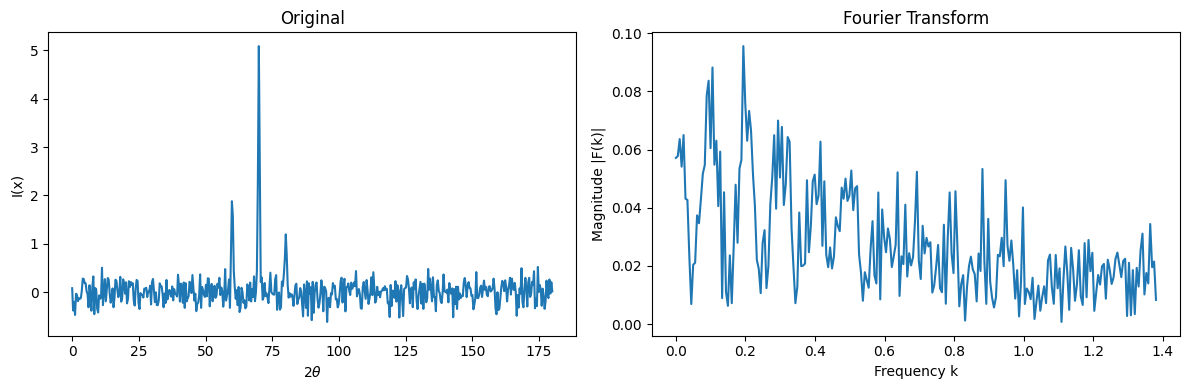

In [4]:
analyser.plot_reference_fourier(b1=70, b2=80, b3 = 60, add_noise=False)
analyser.plot_reference_fourier(b1=70, b2=80, b3 = 60, add_noise=True)

---> Fourier transform of summed up opXRD patterns

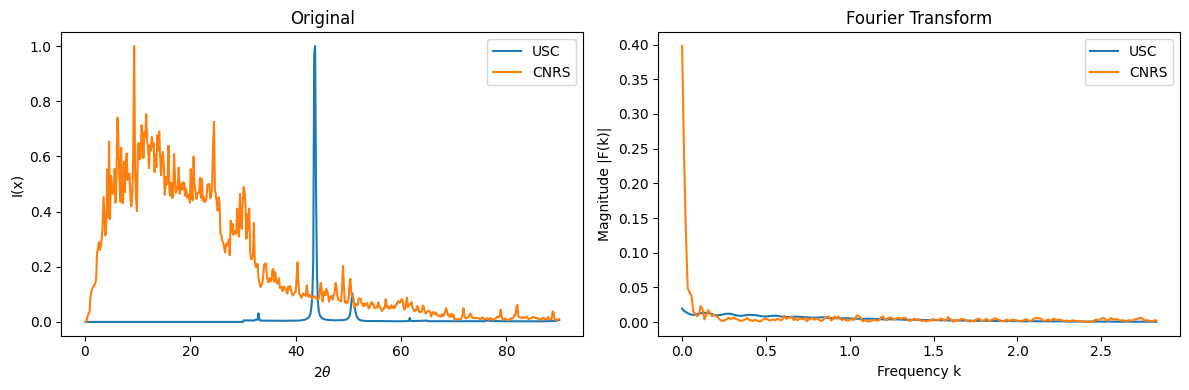

In [5]:
analyser.plot_opxrd_fourier()

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 10

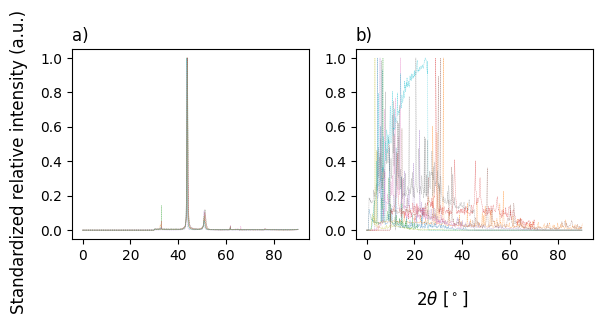

In [6]:
analyser.plot_in_single(limit_patterns=10)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 50

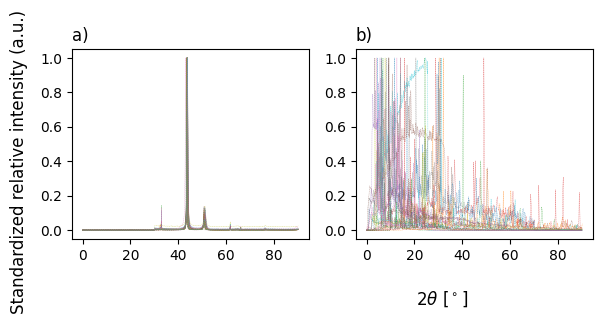

In [7]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 100

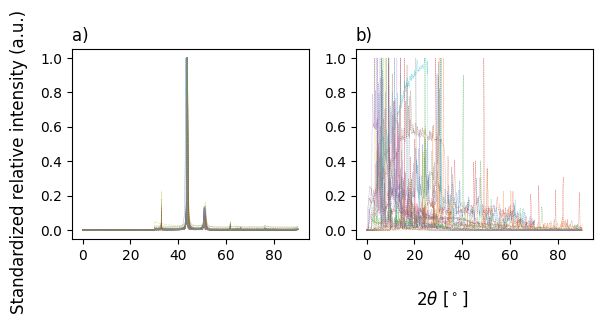

In [8]:
analyser.plot_in_single(limit_patterns=100)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 1000

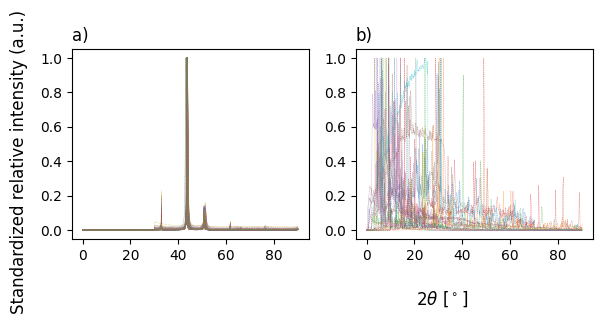

In [9]:
analyser.plot_in_single(limit_patterns=1000)

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 174
[Debug]: Performing PCA for CNRS | No. patterns = 27


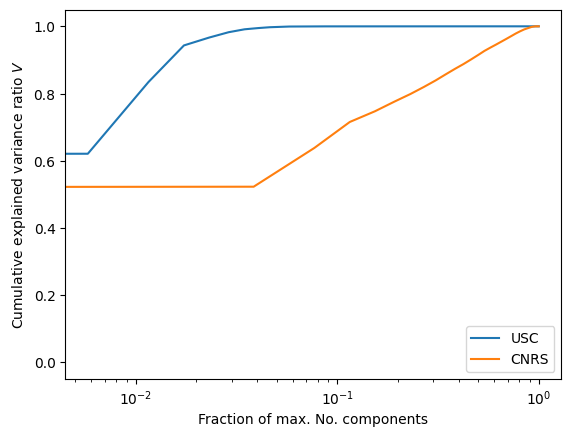

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 174
[Debug]: Performing PCA for CNRS | No. patterns = 27


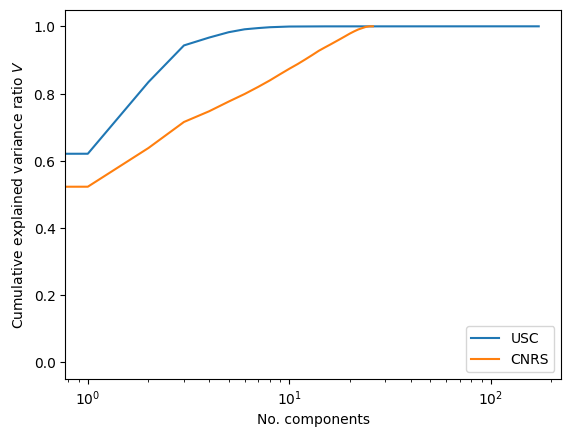

In [10]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

---> Histogram of general information on opXRD

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


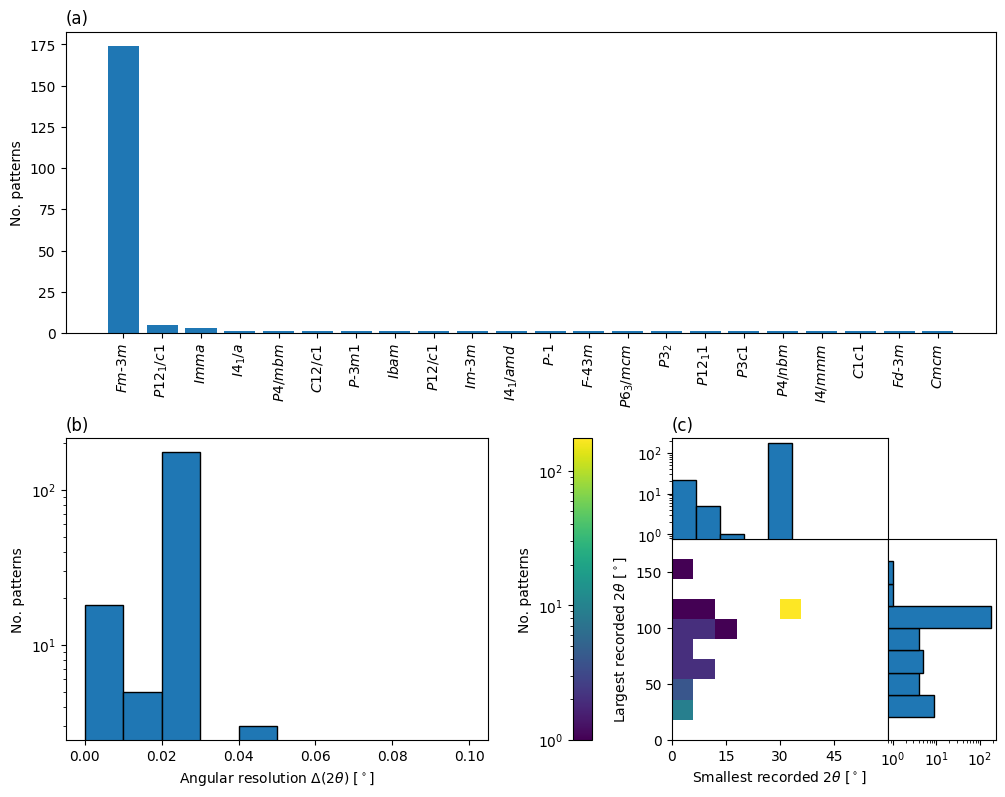

In [11]:
analyser.plot_histogram()

In [12]:
analyser.show_label_fractions()
analyser.print_total_counts()

---> Overview of label fractions per contribution

+------+-------+-----------+---------------+---------------+
|      |   spg |   lattice |   atom_coords |   composition |
|------+-------+-----------+---------------+---------------|
| USC  |     1 |  0.994253 |      0        |      1        |
| CNRS |     1 |  1        |      0.814815 |      0.814815 |
+------+-------+-----------+---------------+---------------+


---> Total pattern counts in opXRD

Total number of patterns = 201
Number of labeled patterns = 201
